In [1]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import glob
from argparse import ArgumentParser
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(threshold = 30)
from Functions import transform_vertex, dy_faces_information
from Functions import dy_surface_distance, surface_distance_part, smoothloss, neg_Jdet_loss, transformation_fold_loss, bdloss, scaling_loss, sampling_grid, GaussianSmoothing#generate_grid
from Functions import loss_plot_save,mse

In [2]:
print_all = True
lr =1
lr_decay = False #True
decay_rate = 0.5
decay_steps = 10#100
scaling =True
scaling_time = 2
scaling_times = (scaling_time, scaling_time, scaling_time)
scaling_ratio = 1.
iteration = 100
antifold = 80.
antifold_para = 80.
negGradient = 0.
negGradient_para = 0.
smooth = 80.
smooth_para =80.
fidelity = 1. #精度
similarity ='MIND'#好像没用
n_checkpoint = 5
casename = 'abdomens_all'
caseNo = '100'
stepsize =8
optimization ='Adam'
varifold = 'currents'
folderpath = '/opt/data/private/varifold/'
casepath='/opt/data/private/varifold/Case/abdomens_all/100/dy'

In [3]:
with open(casepath + "/parameter_list.txt","w") as f:
    f.write('## train parameter' + '\n')
    f.write("learning rate: " + str(lr) + '\n') 
    f.write("iteration: " + str(iteration) + '\n')
    f.write("optimization: " + str(optimization) + '\n')   
    f.write("n_checkpoint: " + str(n_checkpoint) + '\n')
    f.write('\n' + '## loss parameter' + '\n')
    f.write('# similarity' + '\n')
    f.write("similarity: " + str(similarity) + '\n\n')  
    f.write('# anti-fold' + '\n')
    f.write("negative Jdet: " + str(antifold) + '\n')   
    f.write("negative Gradient: " + str(negGradient) + '\n\n')  
    f.write('# smooth' + '\n')
    f.write("smooth: " + str(smooth) + '\n\n')  

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_varifold = dy_surface_distance
loss_smooth = smoothloss
loss_Jdet = neg_Jdet_loss
loss_fold = transformation_fold_loss
loss_bd = bdloss
loss_scaling_ratio = scaling_loss
lossall = np.zeros((7, iteration + 1))

In [5]:
# # Load the data
if casename == 'abdomens_all':
    imgshape = (224, 512, 640)
    #organ_list = [1,2,3,6,7]
    #step_size = data_step_size
    caseNo_path = folderpath + 'Case/' + casename + '/' + caseNo + '/dy_data/'
    fixed_vert_list_path = glob.glob(caseNo_path + r'/*/vert_fixed_' + str(stepsize) + '.npy')
    fixed_organ_list = [path.split(caseNo + '/dy_data/')[1].split('/vert_fixed')[0] for path in fixed_vert_list_path]
    moving_vert_list_path = glob.glob(caseNo_path + r'/*/vert_moving_' + str(stepsize) + '.npy')
    moving_organ_list = [path.split(caseNo + '/dy_data/')[1].split('/vert_moving')[0] for path in moving_vert_list_path]
    organ_list = list(set(fixed_organ_list) & set(moving_organ_list))
    organ_list.sort()
    print(organ_list)
    with open(casepath + "/parameter_list.txt","a") as f:
        f.write('\n\n')
        f.write('## organ list' + '\n')
        f.write("organ list: " + str(organ_list) + '\n')
    fixed_vert_lists = list()
    fixed_face_lists = list()
    moving_vert_lists = list()
    moving_face_lists = list()
    for organ_index in organ_list:
        fixed_vert_list = torch.from_numpy(np.load(caseNo_path + organ_index + '/vert_fixed_' + str(stepsize) + '.npy')).to(device).float()
        fixed_face_list = torch.from_numpy(np.load(caseNo_path + organ_index + '/face_fixed_' + str(stepsize) + '.npy')).to(device)
        moving_vert_list = torch.from_numpy(np.load(caseNo_path + organ_index + '/vert_moving_' + str(stepsize) + '.npy')).to(device).float()
        moving_face_list = torch.from_numpy(np.load(caseNo_path + organ_index + '/face_moving_' + str(stepsize) + '.npy')).to(device)
        fixed_vert_lists.append(fixed_vert_list)
        fixed_face_lists.append(fixed_face_list)
        moving_vert_lists.append(moving_vert_list)
        moving_face_lists.append(moving_face_list)
        print('fixed points:',fixed_vert_list.shape[0],'\t' + 'fixed points:',moving_vert_list.shape[0])
        #print(fixed_vert_lists[-1].shape)
        #print(moving_vert_lists[-1].shape)

#start_time = time.time()

if scaling == True:
    gridshape = (round(imgshape[0] / scaling_times[0]), round(imgshape[1] / scaling_times[1]), round(imgshape[2] / scaling_times[2]))
    
    for l in range(len(organ_list)):
    
        moving_vert_lists[l][:,0] = moving_vert_lists[l][:,0] / scaling_times[0]
        moving_vert_lists[l][:,1] = moving_vert_lists[l][:,1] / scaling_times[1]
        moving_vert_lists[l][:,2] = moving_vert_lists[l][:,2] / scaling_times[2]

        fixed_vert_lists[l][:,0] = fixed_vert_lists[l][:,0] / scaling_times[0]
        fixed_vert_lists[l][:,1] = fixed_vert_lists[l][:,1] / scaling_times[1]
        fixed_vert_lists[l][:,2] = fixed_vert_lists[l][:,2] / scaling_times[2]
        
        print(fixed_vert_lists[l])
        print(moving_vert_lists[l])

else:
    gridshape = imgshape


print('scaling_times:', scaling_times)

grid = sampling_grid(gridshape).to(device)
print(grid.shape)

['4']
fixed points: 774 	fixed points: 990
tensor([[ 18.0000, 104.0000, 156.0000],
        [ 20.0000, 104.0000, 152.4987],
        [ 20.0000, 102.0000, 156.0000],
        ...,
        [ 78.0000, 148.0000, 196.0000],
        [ 80.0000, 145.6092, 200.0000],
        [ 81.6092, 144.0000, 200.0000]], device='cuda:0')
tensor([[ 18., 108., 160.],
        [ 20., 108., 158.],
        [ 20., 106., 160.],
        ...,
        [ 78., 164., 188.],
        [ 78., 164., 192.],
        [ 78., 164., 196.]], device='cuda:0')
scaling_times: (2, 2, 2)
torch.Size([1, 3, 112, 256, 320])


In [6]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vert_moving_lists = list()
normal_moving_lists = list()
area_moving_lists = list()
cur_moving_lists=list()
for l in range(len(organ_list)):
    vert_moving, normal_moving, area_moving,cur_moving = dy_faces_information(moving_vert_lists[l], moving_face_lists[l])
    vert_moving_lists.append(vert_moving)
    normal_moving_lists.append(normal_moving)
    area_moving_lists.append(area_moving)
    cur_moving_lists.append(cur_moving)


In [7]:
## Create optimisable displacement grid
#net = nn.Sequential(nn.Conv3d(3,1,imgshape,bias=False))
net = nn.Sequential(nn.Conv3d(3,1,gridshape,bias=False))
#net[0].weight.data[:] = disp_lr/grid_sp
net.to(device)
print(net[0].weight.shape)

torch.Size([1, 3, 112, 256, 320])


In [8]:
padding_size = 30
kernel_size = 2 * padding_size + 1
sigma = 30
smoothing = GaussianSmoothing(3, kernel_size, sigma, dim = 3).to(device)

## Set the optimizer
if optimization == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr)
elif optimization == 'SGD':
    optimizer = torch.optim.SGD(net.parameters(), lr)

Calculate the position of the points on the surface after the space transformation: finished
Calculate the face information of the surface: finished
70
loss_fidelity: tensor(294774.0938, grad_fn=<AddBackward0>)
Calculate the distance between the warped surface and the moving surface: finished
Calculate the regularity term of the displacement field: finished
Calculate the energy functional: finished
Optimize the displacement field: finished
step "1" -> training loss "294774.0938" - varifold "294774.093750" -smo "0.0000000242" -bd "0.0000000000" - Jdet "0.0000000000" -negGrad "0.0000000000" -scaling "0.0000000000"
Calculate the position of the points on the surface after the space transformation: finished
Calculate the face information of the surface: finished
70
loss_fidelity: tensor(271075.1875, grad_fn=<AddBackward0>)
Calculate the distance between the warped surface and the moving surface: finished
Calculate the regularity term of the displacement field: finished
Calculate the energy

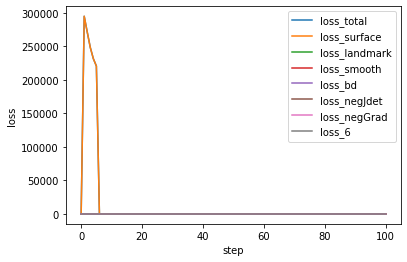

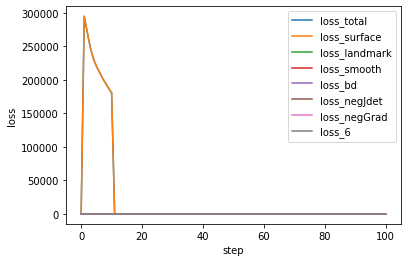

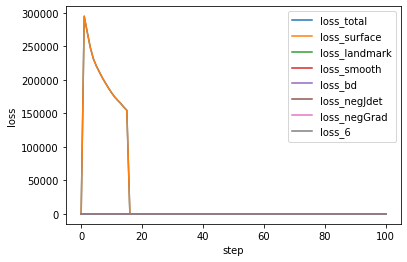

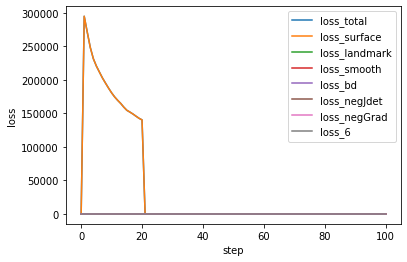

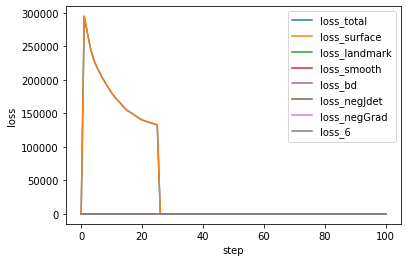

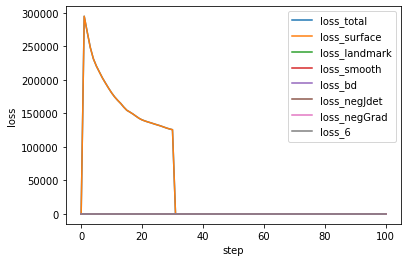

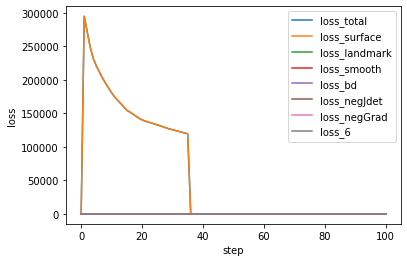

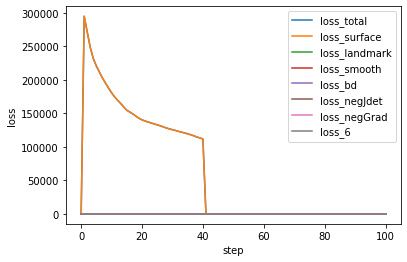

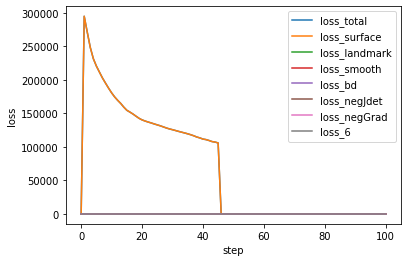

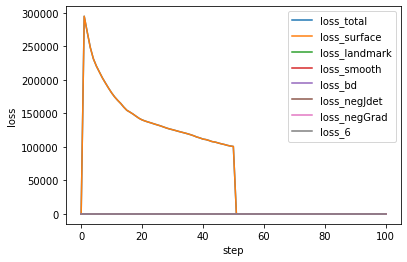

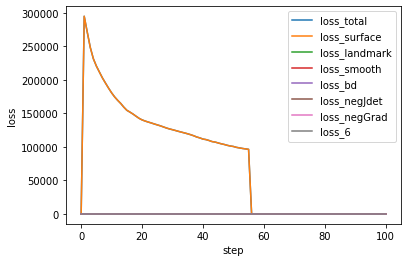

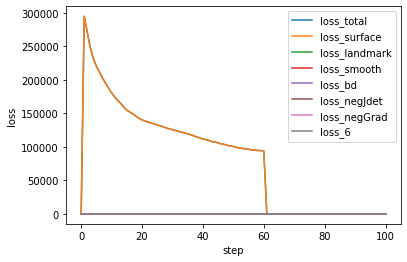

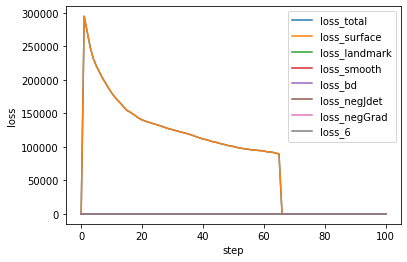

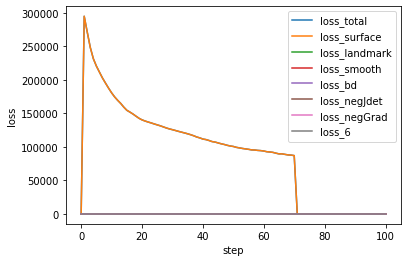

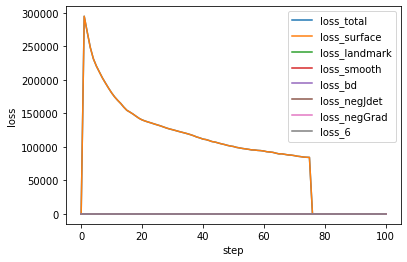

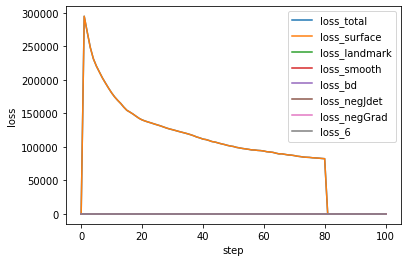

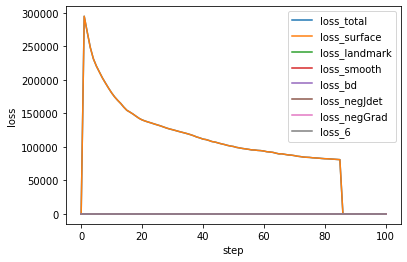

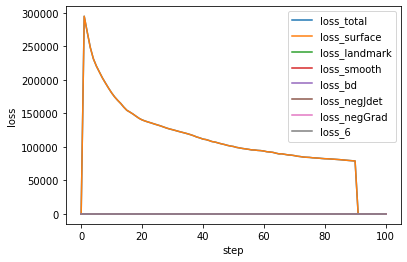

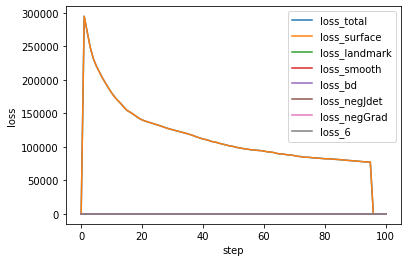

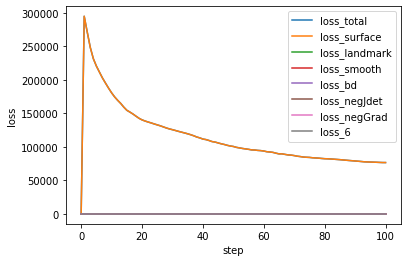

In [9]:
step = 1
POS=2
while step <= iteration:
    if lr_decay == True:
        if (step % decay_steps == 0): # and lr>0.01
            lr = lr * decay_rate
            POS=POS*0.95
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    
    if False:#smoothing == True:
        if (step - 1) % 400 == 0:
            input = F.pad(net[0].weight, (padding_size, padding_size, padding_size, padding_size, padding_size, padding_size), mode='replicate').to(device)
            #print(smoothing(input).shape)
            net[0].weight = nn.Parameter(smoothing(input).to(device))#[ : , : , padding_size : -padding_size, padding_size : -padding_size, padding_size : -padding_size]
            #lr = lr * 0.1
            POS=POS*0.95            
            if optimization == 'Adam':
                optimizer = torch.optim.Adam(net.parameters(), lr)
            elif optimization == 'SGD':
                optimizer = torch.optim.SGD(net.parameters(), lr)
    
    optimizer.zero_grad()
    
    transformed_vert_lists = list()
    for l in range(len(organ_list)):
        transformed_vert_list = transform_vertex(fixed_vert_lists[l], gridshape, net[0].weight) #type: tensor
        transformed_vert_lists.append(transformed_vert_list)
        
    if print_all == True:
        print('Calculate the position of the points on the surface after the space transformation: finished')
    
    
    vert_transformed_lists = list()
    normal_transformed_lists = list()
    area_transformed_lists = list()
    cur_transformed_lists=list()
    for l in range(len(organ_list)):
        vert_transformed, normal_transformed, area_transformed,cur_transformed= dy_faces_information(transformed_vert_lists[l], fixed_face_lists[l])
        vert_transformed_lists.append(vert_transformed)
        normal_transformed_lists.append(normal_transformed)
        area_transformed_lists.append(area_transformed)
        cur_transformed_lists.append(cur_transformed)
    if print_all == True:
        print('Calculate the face information of the surface: finished')
    
    ## Calculate the distance between the warped surface and the moving surface
    loss_fidelity = 0
    for l in range(len(organ_list)):
         loss_fidelity += loss_varifold(vert_moving_lists[l], vert_transformed_lists[l], 
                                       normal_moving_lists[l], normal_transformed_lists[l],
                                        cur_moving_lists[l], cur_transformed_lists[l],
                                       area_moving_lists[l], area_transformed_lists[l],
                                        radial_kernel = 'Gaussian',
                                       spherical_kernel = 'currents',
                                        sigma_pos = POS, sigma_or = 0.10)#sigma_pos = sigma_position
    print('loss_fidelity:',loss_fidelity)
    
    if print_all == True:
        print('Calculate the distance between the warped surface and the moving surface: finished')    
   
    

    ## Calculate the regularity term of the displacement field
    loss_Jacobian = loss_Jdet(net[0].weight[:,[2,1,0],], grid[:,[2,1,0],])
     
    loss_grad_fold = loss_fold(net[0].weight[:,[2,1,0],], grid[:,[2,1,0],])
    
    loss_regulation = loss_smooth(net[0].weight)
    
    loss_regulation1 = torch.zeros(1)
    
    loss_scaling = torch.zeros(1)
    
    if print_all == True:
        print('Calculate the regularity term of the displacement field: finished') 
    ## Calculate the energy functional (loss)
    loss = 1 * loss_fidelity + smooth * loss_regulation + antifold * loss_Jacobian# + negGradient * loss_grad_fold# + loss_scaling_ratio * loss_scaling
    
    if print_all == True:
        print('Calculate the energy functional: finished') 
    #print('6')
    
    ## Optimize the displacement field
    # optimizer.zero_grad()           # clear gradients for this training step
    loss.backward()                 # backpropagation, compute gradients
    optimizer.step()                # apply gradients
    if print_all == True:
        print('Optimize the displacement field: finished') 
    
    ## Print terms of the energy functional (loss)loss_fidelity是int类型
    lossall[:, step] = torch.tensor([loss.item(), loss_fidelity, loss_regulation.item(), loss_regulation1.item(), loss_Jacobian.item(), loss_grad_fold.item(), loss_scaling.item()])
    

    sys.stdout.write( "\r" + 'step "{0}" -> training loss "{1:.4f}" - varifold "{2:4f}" -smo "{3:.10f}" -bd "{4:.10f}" - Jdet "{5:.10f}" -negGrad "{6:.10f}" -scaling "{7:.10f}"\n'.format(step, loss.item(), loss_fidelity, loss_regulation.item(), loss_regulation1.item(), loss_Jacobian.item(), loss_grad_fold.item(), loss_scaling.item()))
    sys.stdout.flush()

   
    
    # Save the loss record
    np.save(casepath + '/loss/' + 'loss_record_newest.npy', lossall)

    ## Save the displacement field, the position of the points on the surface after the space transformation, the loss record
    if (step % n_checkpoint == 0):
        # Save the displacement field
        torch.save(net.state_dict(), casepath + '/flow_pth/' + 'net_' + str(step) + '.pth')
        
        # Save the position of the points on the surface after the space transformation
     
        
        for l in range(len(organ_list)):
            transformed_vert_list = transformed_vert_lists[l].cpu().detach().numpy()     
            np.save(casepath + '/vertex_npy/vert_transformed_' + str(organ_list[l]) + '_it' + str(step) + '.npy', transformed_vert_list)
            np.save(casepath + '/vertex_npy/vert_transformed_' + str(organ_list[l]) + '_newest.npy', transformed_vert_list)
        
        # Save the loss record
        np.save(casepath + '/loss/' + 'loss_record_it' + str(step) + '.npy', lossall)
        loss_plot_save(lossall, casepath + '/' + 'loss.png')

    
    step += 1
    
    if step > iteration:
        break

In [10]:
print("Iteration ended.")
#end_time = time.time()
#time_spent = end_time - start_time
#with open(casepath + "/parameter_list.txt","a") as f:
    #f.write('\n\n')
   # f.write('## train time' + '\n')
   # f.write("train time: " + str(time_spent) + 's\n')

## Save the displacement field, the position of the points on the surface after the space transformation, the loss record
# Save the displacement field
torch.save(net.state_dict(), casepath + '/flow_pth/net_final.pth')

# Save the loss record
np.save(casepath + '/loss/loss_record_final.npy', lossall)

# Save the position of the points on the surface after the space transformation
# transformed_vert_list = vert_list_transformed_tensor.cpu().detach().numpy()
# np.save(casepath + 'vert_transformed_final.npy', transformed_vert_list)

for l in range(len(organ_list)):
    transformed_vert_list = transformed_vert_lists[l].cpu().detach().numpy()
    np.save(casepath + '/vertex_npy/vert_transformed_' + str(organ_list[l]) + '_final.npy', transformed_vert_list)



# python /opt/data/private/varifold/train_varifold_abdomens.py

Iteration ended.
